In [1]:
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt
from scipy.optimize import fsolve
from numpy.linalg import matrix_power

In [8]:
def TMM_HomoWG_Matrix(wavelength, l, neff, loss):
# Calculate the transfer matrix of a homogeneous waveguide.
# Complex propagation constant
    beta=2*np.pi*neff/wavelength-1j*loss/2
    T_hw=np.zeros((2, 2), dtype=complex)
    T_hw[0,0]=np.exp(1j*beta*l)
    T_hw[1,1]=np.exp(-1j*beta*l)

    return T_hw

def TMM_IndexStep_Matrix(n1,n2):
# Calculate the transfer matrix for a index step from n1 to n2.
    T_is=np.zeros((2, 2), dtype=complex)
    a=(n1+n2)/(2*np.sqrt(n1*n2))
    b=(n1-n2)/(2*np.sqrt(n1*n2))
    T_is[0,0]=a; T_is[0,1]=b
    T_is[1,0]=b; T_is[1,1]=a

    return T_is

def TMM_Grating_Matrix(wavelength, Period, NG, n1, n2, loss):
# Calculate the total transfer matrix of the gratings
    l=Period/2
    T_hw1=TMM_HomoWG_Matrix(wavelength,l,n1,loss)
    T_is12=TMM_IndexStep_Matrix(n1,n2)
    T_hw2=TMM_HomoWG_Matrix(wavelength,l,n2,loss)
    T_is21=TMM_IndexStep_Matrix(n2,n1)
    Tp=np.zeros((2,2), dtype=complex)
    T=Tp

    Tp=T_hw2 @ T_is21 @ T_hw1 @ T_is12
    T=matrix_power(Tp, NG)  # 1st order uniform Bragg grating
        
    # for an FP cavity, 1st order cavity, insert a high index region, n2.
    #T=matrix_power(Tp, NG) @ T_hw2 @ matrix_power(Tp, NG) @ T_hw2

    return T

def TMM_Grating_RT(wavelength, Period, NG, n1, n2, loss):
#Calculate the R and T versus wavelength
    M=TMM_Grating_Matrix(wavelength, Period, NG, n1, n2, loss)
    T=abs(1/M[0,0])**2
    R=abs(M[1,0]/M[0,0])**2

    return R, T

def neff(wavelength):
    neff = 2.4379 - 1.1193*(wavelength*1e6-1.554) - 0.0350*(wavelength*1e6-1.554)**2
    return neff

def dneff(width):
    dneff = 10.4285*(width-0.5)**3 - 5.2487*(width-0.5)**2 + 1.6142*(width-0.5)
    return dneff

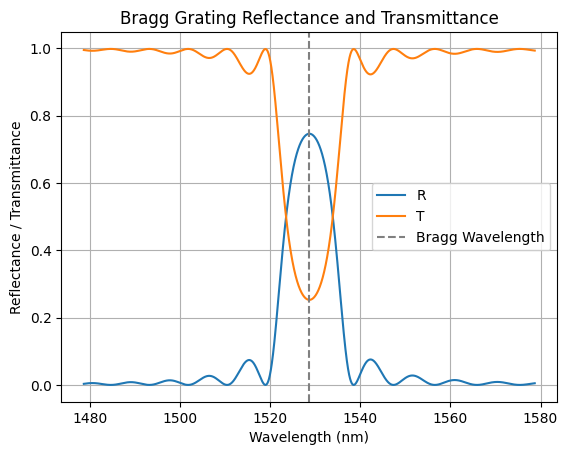

In [11]:
Period = 310e-9
NG = 100
loss = np.log(10)*3/10*100

f = lambda landa: landa - Period*2*(neff(landa) + (dneff(0.51) + dneff(0.49))/2)
bragg_wl = fsolve(f, 1550e-9)[0]

wavelength = np.linspace(-50e-9, 50e-9, 10000) + bragg_wl  

Ref = []
Trans = []
for wl in wavelength:
    n1 = neff(wl)+dneff(0.49)
    n2 = neff(wl)+dneff(0.51)

    R, T = TMM_Grating_RT(wl, Period, NG, n1, n2, loss)
    Ref.append(R)
    Trans.append(T)

plt.plot(wavelength*1e9, Ref, label='R')
plt.plot(wavelength*1e9, Trans, label='T')
plt.axvline(x=bragg_wl*1e9, color='gray', linestyle='--', label='Bragg Wavelength')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Reflectance / Transmittance')
plt.title('Bragg Grating Reflectance and Transmittance')
plt.legend()
plt.grid()
plt.show()